## Installing Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/vox1_dev_wav.zip -d /content/wav_files

Archive:  /content/drive/MyDrive/vox1_dev_wav.zip
replace /content/wav_files/wav/id10092/LbVIZMrQGmQ/00001.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
%%capture
# Local installation
!git clone https://github.com/speechbrain/speechbrain/
%cd /content/speechbrain/
!pip install -r requirements.txt
!pip install -e .

In [ ]:
%%capture
!pip install speechbrain

In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install gdown 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gdown 
gdown.download_folder('https://drive.google.com/drive/u/1/folders/1TmDAnOxqLdaCpPCBCeN3Hi3B5MyM_CTY', quiet=True)

['/content/speechbrain/MI Attack files/losses_test.npy',
 '/content/speechbrain/MI Attack files/losses_train.npy',
 '/content/speechbrain/MI Attack files/losses_val.npy',
 '/content/speechbrain/MI Attack files/test_confidences.npy',
 '/content/speechbrain/MI Attack files/test.csv',
 '/content/speechbrain/MI Attack files/train_confidences.npy',
 '/content/speechbrain/MI Attack files/train.csv',
 '/content/speechbrain/MI Attack files/val_confidences.npy',
 '/content/speechbrain/MI Attack files/val.csv']

In [ ]:
import torchaudio
from speechbrain.pretrained import EncoderClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd
import os
from tqdm import tqdm

In [ ]:
#!unzip -l /content/drive/MyDrive/vox1_dev_wav.zip

In [ ]:
#!unzip /content/drive/MyDrive/vox1_dev_wav.zip wav/id11076/86bF4UAieZ0/00007.wav


In [ ]:
train_df = pd.read_csv('/content/speechbrain/MI Attack files/train.csv')
test_df = pd.read_csv('/content/speechbrain/MI Attack files/test.csv')
val_df = pd.read_csv('/content/speechbrain/MI Attack files/val.csv')


In [ ]:
train_df

,Unnamed: 0,ID,duration,wav,start,stop,spk_id,present_label
0,1770953,id10974--HQCxuj-_IEI--00002_300_600,6.360062,/localscratch/voxceleb1/wav/id10974/HQCxuj-_IE...,48000,96000,id10974,True
1,1879771,id11027--cnzoLtP8scQ--00002_0_300,25.920063,/localscratch/voxceleb1/wav/id11027/cnzoLtP8sc...,0,48000,id11027,True
2,1356812,id10899--jEQUmGeTxAA--00002_0_300,4.680063,/localscratch/voxceleb1/wav/id10899/jEQUmGeTxA...,0,48000,id10899,True
3,1642033,id11210--7xaAmL5lPFs--00016_0_300,8.560063,/localscratch/voxceleb1/wav/id11210/7xaAmL5lPF...,0,48000,id11210,True
4,816212,id10561--EK-mIWZ1hWI--00012_0_300,5.040063,/localscratch/voxceleb1/wav/id10561/EK-mIWZ1hW...,0,48000,id10561,True
...,...,...,...,...,...,...,...,...
19995,45658,id10858--8uAVUnozxKQ--00001_0_300,5.800063,/localscratch/voxceleb1/wav/id10858/8uAVUnozxK...,0,48000,id10858,False
19996,207798,id10530--vDN3b85G3N8--00001_600_900,15.160063,/localscratch/voxceleb1/wav/id10530/vDN3b85G3N...,96000,144000,id10530,False
19997,13283,id10609--Gv3w08FRAbs--00001_300_600,8.120062,/localscratch/voxceleb1/wav/id10609/Gv3w08FRAb...,48000,96000,id10609,False
19998,24973,id10067--LWet2zhWjBg--00024_0_300,4.240062,/localscratch/voxceleb1/wav/id10067/LWet2zhWjB...,0,48000,id10067,False


In [ ]:
for f in train_df['wav']:
  l = f.split('/')[3:]
  l = [s+'/' for s in l]
  l[-1] = l[-1][:-1] 
  l = ''.join(l)
  

In [ ]:
%%capture
import speechbrain 
# here we download the material needed for this tutorial: images and an example based on mini-librispeech
!wget https://www.dropbox.com/s/b61lo6gkpuplanq/MiniLibriSpeechTutorial.tar.gz?dl=0
!tar -xvzf MiniLibriSpeechTutorial.tar.gz?dl=0
# downloading mini_librispeech dev data
!wget https://www.openslr.org/resources/31/dev-clean-2.tar.gz
!tar -xvzf dev-clean-2.tar.gz

# Logistic Regression

In [ ]:
target_model = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="./pretrained_ecapa", run_opts={"device": "cuda"},)

In [ ]:
shadow_model = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="./pretrained_ecapa", run_opts={"device": "cuda"},)

In [ ]:
from speechbrain.nnet.losses import LogSoftmaxWrapper, AdditiveAngularMargin


In [ ]:
class MIAttack_train:
  def __init__(self, target_model, shadow_model, classifier): 
    self.target_model = target_model
    self.shadow_model = shadow_model
    self.classifier = classifier


  def query(self, signal, label = None):  #input: signal, fs = torchaudio.load("tests/samples/single-mic/example1.wav")
    embeddings = self.shadow_model.encode_batch(signal)
    output_probs, score, index, text_lab = self.shadow_model.classify_batch(signal)
    #loss = self.loss_func(output_probs, label)
    loss = 0
    #print(len(loss[0]))
    return score, loss

  def get_queried_res(self, data_csv): #input - .wav files
    data_files = data_csv['wav']
    self.labels = []
    

    scores = []
    losses = []
    for i in tqdm(range(len(data_files))):
      f = data_files[i]
      labels = data_csv['present_label']
      f = f.replace("/localscratch/voxceleb1/", "/content/wav_files/")
      try:
        signal, _ = torchaudio.load(f)
        score, loss = self.query(signal, labels[i])
        scores.append([score.item()])
        losses.append([0])
        self.labels.append(labels[i])
      except:
        continue
      
    self.scores = scores
    self.losses = losses
    #self.queries = np.array(self.queries)
    #self.labels = np.array(self.labels)
    return self.scores, self.losses, self.labels 

  def train_classifier(self, data, criteria = 'confidence'):
    scores, losses, labels = self.get_queried_res(data)
    print(scores, losses, labels)
    if criteria=='confidence':
      self.clf = self.classifier.fit(scores, labels )
    else:
      self.clf = self.classifier.fit(losses, labels )
    return self.clf


In [ ]:
class MIAttack_test:
  def __init__(self, target_model, classifier): 
    self.target_model = target_model
    self.shadow_model = shadow_model
    self.classifier = classifier
    self.loss_func= AdditiveAngularMargin()

  def query(self, signal, label = None):  #input: signal, fs = torchaudio.load("tests/samples/single-mic/example1.wav")
    embeddings = self.shadow_model.encode_batch(signal)
    output_probs, score, index, text_lab = self.shadow_model.classify_batch(signal)
    #loss = self.loss_func(output_probs, label)
    loss =0 
    return score, loss

  def get_queried_res(self, data_csv): #input - .wav files
    data_files = data_csv['wav']
    labels = data_csv['present_label']
    self.labels = []
    scores = []
    losses = []
    for i in tqdm(range(len(data_files))):
      f = data_files[i]
      f = f.replace("/localscratch/voxceleb1/", "/content/wav_files/")
      try:
        signal, _ = torchaudio.load(f)
        score, loss = self.query(signal)
        scores.append([score.item()])
        losses.append([0])
        self.labels.append(labels[i])
      except:
        continue
      
      
      
    self.scores = scores
    self.losses = losses
    #self.queries = np.array(self.queries)
    #self.labels = np.array(self.labels)
    return self.scores, self.losses, self.labels 


  def test_classifier(self, data, criteria='confidence'):
    scores, losses, labels = self.get_queried_res(data)
    if criteria=='confidence':
      res = self.classifier.predict(scores)
    else:
      res = self.classifier.predict(labels)
    #score = classifier.score(queries, labels)
    score = classification_report(res, labels)
    return res, score

In [ ]:
d = {'wav':['/content/speechbrain/tests/samples/single-mic/example1.wav', '/content/speechbrain/tests/samples/single-mic/example1.wav'], 'present_label':[True, False]}

In [ ]:
clf = LogisticRegression(max_iter=1000)

In [ ]:
criteria = 'confidence'
percentages = [0.2, 0.5, 1]

import numpy as np
chosen_idx = np.random.choice(len(train_df), replace=False, size=int(len(train_df)))
len(chosen_idx)
df1 = train_df.iloc[chosen_idx]

clf = LogisticRegression(random_state=0, max_iter=500) 
mi_train = MIAttack_train(target_model, shadow_model, clf)
trained_classifier = mi_train.train_classifier(df1.reset_index())
mi_test = MIAttack_test(target_model, trained_classifier )
res, score = mi_test.test_classifier(test_df)

100%|██████████| 20000/20000 [14:17<00:00, 23.32it/s]


[[0.7084888219833374], [0.7954687476158142], [0.8826690912246704], [0.5281796455383301], [0.7668464183807373], [0.8500983715057373], [0.7777146100997925], [0.7438521385192871], [0.7681501507759094], [0.6714156866073608], [0.8238263726234436], [0.7274799942970276], [0.7945000529289246], [0.8301717638969421], [0.749549388885498], [0.824113130569458], [0.7602047324180603], [0.8015329241752625], [0.7925829291343689], [0.7527070641517639], [0.8551550507545471], [0.7762241363525391], [0.8915523290634155], [0.8542624711990356], [0.8384540677070618], [0.7055705189704895], [0.7497384548187256], [0.8310770988464355], [0.7611984610557556], [0.8001548051834106], [0.7991031408309937], [0.8085125684738159], [0.6506051421165466], [0.713378369808197], [0.6995487809181213], [0.7531952857971191], [0.8373554348945618], [0.8528879284858704], [0.7137693762779236], [0.7008523344993591], [0.7684946656227112], [0.8349029421806335], [0.8654372692108154], [0.7722771167755127], [0.819158673286438], [0.7632418870

100%|██████████| 4000/4000 [02:50<00:00, 23.51it/s]


In [ ]:
print('logistic regression test- 100%\n')
print(res)

logistic regression test- 0.2%

[ True False False ... False False  True]


In [ ]:
print(score)

              precision    recall  f1-score   support

       False       0.45      0.53      0.49      1299
        True       0.60      0.52      0.56      1779

    accuracy                           0.53      3078
   macro avg       0.53      0.53      0.52      3078
weighted avg       0.54      0.53      0.53      3078



In [ ]:
print('logistic regression val- 100%\n')
mi_val = MIAttack_test(target_model, trained_classifier )
res, score = mi_val.test_classifier(val_df)
print(res)

logistic regression val- 100%



100%|██████████| 4000/4000 [02:43<00:00, 24.42it/s]

[ True  True  True ... False False False]


In [ ]:
print(score)

              precision    recall  f1-score   support

       False       0.46      0.54      0.50      1268
        True       0.62      0.53      0.57      1763

    accuracy                           0.54      3031
   macro avg       0.54      0.54      0.53      3031
weighted avg       0.55      0.54      0.54      3031



In [ ]:
from sklearn import svm
clf = svm.SVC()
a = clf.fit(mi_train.scores, mi_train.labels)
res = clf.predict(mi_test.scores)
print('svm test- 100%\n')
print(classification_report(res, mi_test.labels))

svm test- 100%

              precision    recall  f1-score   support

       False       0.39      0.53      0.45      1129
        True       0.66      0.52      0.58      1949

    accuracy                           0.52      3078
   macro avg       0.52      0.53      0.52      3078
weighted avg       0.56      0.52      0.53      3078



In [ ]:
res = clf.predict(mi_val.scores)
print('svm val- 0.2%\n')
print(classification_report(res, mi_val.labels))

svm val- 0.2%

              precision    recall  f1-score   support

       False       0.39      0.54      0.46      1094
        True       0.67      0.53      0.59      1937

    accuracy                           0.53      3031
   macro avg       0.53      0.54      0.52      3031
weighted avg       0.57      0.53      0.54      3031



In [ ]:
criteria = 'confidence'
percentages = [0.2, 0.5, 1]

import numpy as np
chosen_idx = np.random.choice(len(train_df), replace=False, size=int(len(train_df)*0.5))
len(chosen_idx)
df2 = train_df.iloc[chosen_idx]

clf2 = LogisticRegression(random_state=0, max_iter=1000)
mi_train2 = MIAttack_train(target_model, shadow_model, clf2)
trained_classifier2 = mi_train2.train_classifier(df2.reset_index())


In [ ]:
mi_test2 = MIAttack_test(target_model, trained_classifier2 )
res, score = mi_test2.test_classifier(test_df)
print('logistic regression test- 0.5%\n')
print(score)

In [ ]:
print('logistic regression val- 0.5%\n')
mi_val2 = MIAttack_test(target_model, trained_classifier )
res, score = mi_val2.test_classifier(val_df)
print(score)

In [ ]:
from sklearn import svm
clf = svm.SVC()
a = clf.fit(mi_train2.scores, mi_train2.labels)
res = clf.predict(mi_test2.scores)
print('svm test- 0.5%\n')
print(classification_report(res, mi_test2.labels))

In [ ]:
res = clf.predict(mi_val2.scores)
print('svm val- 0.5%\n')
print(classification_report(res, mi_val2.labels))

In [ ]:
criteria = 'confidence'
percentages = [0.2, 0.5, 1]

import numpy as np
chosen_idx = np.random.choice(len(train_df), replace=False, size=int(len(train_df)*0.5))
len(chosen_idx)
df3 = train_df.iloc[chosen_idx]

clf3 = LogisticRegression(random_state=0, max_iter=1000)
mi_train3 = MIAttack_train(target_model, shadow_model, clf3)
trained_classifier3 = mi_train2.train_classifier(train_df)
mi_test3 = MIAttack_test(target_model, trained_classifier3 )
res, score = mi_test3.test_classifier(test_df)

In [ ]:
print('logistic regression test- 0.5%\n')
print(res)

In [ ]:
print('logistic regression val- 0.5%\n')
mi_val3 = MIAttack_test(target_model, trained_classifier )
res, score = mi_val3.test_classifier(val_df)
print(score)

In [ ]:
from sklearn import svm
clf = svm.SVC()
a = clf.fit(mi_train3.scores, mi_train3.labels)
res = clf.predict(mi_test3.scores)
print('svm test- 0.5%\n')
print(classification_report(res, mi_test3.labels))

In [ ]:
res = clf.predict(mi_val3.scores)
print('svm val- 1%\n')
print(classification_report(res, mi_val3.labels))

In [ ]:
count = 0
for i in mi_test2.labels:
  if i==False:
    count+=1
count

In [ ]:
print(score)

In [ ]:
clf_ = LogisticRegression(max_iter=10)
clf_.fit(mi_train2.scores, mi_train2.labels)
res = clf2.predict(mi_test2.scores)
print(classification_report(res, mi_test2.labels))

In [ ]:
from sklearn import svm
clf = svm.SVC()
a = clf.fit(mi_train2.scores, mi_train2.labels)
res = clf.predict(mi_test2.scores)
print(classification_report(res, mi_test2.labels))

In [ ]:
clf = LogisticRegression(max_iter=500).fit(mi_train2.scores, mi_train2.labels)
#clf.predict(X[:2, :])

#clf.predict_proba(X[:2, :])
x = clf.score(mi_test2.scores, mi_test2.labels)

In [ ]:
print(x)

In [ ]:
criteria = 'confidence'
percentages = [0.2, 0.5, 1]

import numpy as np
chosen_idx = np.random.choice(len(train_df), replace=False, size=int(len(train_df)*percentages[2]))
len(chosen_idx)
df3 = train_df.iloc[chosen_idx]

clf3 = LogisticRegression(random_state=0)
mi_train3 = MIAttack_train(target_model, shadow_model, clf3)
trained_classifier3 = mi_train3.train_classifier(df3.reset_index())
mi_test3 = MIAttack_test(target_model, trained_classifier3 )
res, score = mi_test3.test_classifier(test_df)

In [ ]:
mi_test3 = MIAttack_test(target_model, trained_classifier3 )
res, score = mi_test3.test_classifier(test_df)

In [ ]:
print(score)

In [ ]:
confidences, labels = mi_test3.scores, mi_test3.labels

In [ ]:
labels[0]

In [ ]:
fin = np.zeros((len(confidences), 2))

for i in range(len(confidences)):
  fin[i, 0] = confidences[i][0]
  fin[i, 1] = labels[0]
fin

In [ ]:
%cd /content

In [ ]:
with open('test_confidences.npy', 'wb') as f:
    np.save(f, fin)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

plt.title('Confidence Inference Plot')
plt.scatter(confidences, labels, alpha=0.5)
plt.show()

# Load and Plot

In [ ]:
train_losses = np.load('/content/speechbrain/MI Attack files/losses_train.npy')

In [ ]:
train_losses[0]
pos_losses, neg_losses = [], []
for i in range(len(train_losses)):
  if train_losses[i][1]:
    pos_losses.append(train_losses[i][0])
  else:
    neg_losses.append(train_losses[i][0])

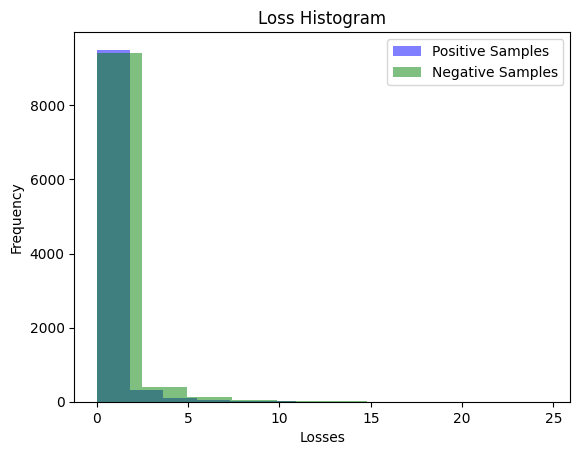

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random data
#x = np.random.normal(0, 1, 1000)
#y = np.random.normal(3, 1, 1000)

# Plot histograms
plt.hist(pos_losses, bins=10, alpha=0.5, color='blue')
plt.hist(neg_losses, bins=10, alpha=0.5, color='green')

# Add labels and legend
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.legend(['Positive Samples', 'Negative Samples'])
plt.title('Loss Histogram')

# Show the plot
plt.show()


In [ ]:
train_confidences = np.load('/content/speechbrain/MI Attack files/train_confidences.npy')

In [ ]:
train_confidences[0]
pos_confidences, neg_confidences = [], []
for i in range(len(mi_train.scores)):
  if mi_train.labels[i]:
    pos_confidences.append(mi_train.scores[i][0])
  else:
    neg_confidences.append(mi_train.scores[i][0])

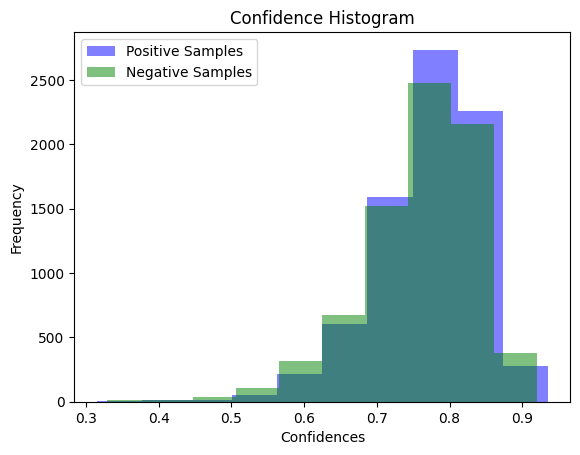

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random data
#x = np.random.normal(0, 1, 1000)
#y = np.random.normal(3, 1, 1000)

# Plot histograms
plt.hist(pos_confidences, bins=10, alpha=0.5, color='blue')
plt.hist(neg_confidences, bins=10, alpha=0.5, color='green')

# Add labels and legend
plt.xlabel('Confidences')
plt.ylabel('Frequency')
plt.legend(['Positive Samples', 'Negative Samples'])
plt.title('Confidence Histogram')

# Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

plt.title('Losses Inference Plot')
plt.scatter(losses, labels, alpha=0.5)
plt.show()

In [ ]:
clf_ = LogisticRegression(max_iter=500)
clf_.fit(mi_train2.scores, mi_train2.labels)
res = clf2.predict(mi_test2.scores)
print(classification_report(res, mi_test2.labels))

# New section

In [ ]:
from sklearn import svm
clf = svm.SVC()
a = clf.fit(losses, labels)

In [ ]:
test_losses_full =  np.load('/content/speechbrain/MI Attack files/test.npy')
test_losses, test_labels = [], []
for i in range(len(test_losses_full)):
  test_losses.append([test_losses_full[i][0]])
  test_labels.append([test_losses_full[i][1]])

In [ ]:
test_losses[0]

In [ ]:
res = clf.predict(test_losses)
print(classification_report(res, test_labels))

In [ ]:
clf_ = LogisticRegression(max_iter=2000)
clf_.fit(losses, labels)
res = clf_.predict(test_losses)
print(classification_report(res, test_labels))

# Get data

In [ ]:
mi = MIAttack_train(target_model, shadow_model, clf)

In [ ]:
train_percents = [20, 50, 100]

In [ ]:
trained_classifier = mi.train_classifier(d)

In [ ]:
mi_test = MIAttack_test(target_model, clf)

In [ ]:
res, score = mi_test.test_classifier(trained_classifier, d)